# TM10007 Assignment

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.9 MB/s eta 0:00:00


## Import packages

In [2]:
import pandas as pd

from worcgist.load_data import load_data

import numpy as np
import pandas as pd
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, VarianceThreshold
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## 1. Data loading

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [3]:
# Load data
data = load_data()

data['label'] = data['label'].map({'non-GIST': 0, 'GIST': 1})

y = data['label']
X = data.drop(columns=['label'])

# Calculate basic statistics
n_samples = len(y)
n_features = len(X.columns)

n_missing = data.isna().sum().sum()
n_zero = (data == 0).sum().sum()

n_non_gist = (y == 0).sum().sum()
n_gist = (y == 1).sum().sum()


In [4]:
# Print basic statistics
print(f'The number of samples: {n_samples}')
print(f'The number of features: {n_features}')
print(f'The number of datapoints: {n_samples * n_features}')
print(f"The number of missing values: {n_missing}")
print(f"The number of zero values: {n_zero}")
print(f"The percentage of zero values: {n_non_gist/(n_samples*n_features)*100} %")
print(f"The percentage of GIST tumors: {n_gist/n_samples*100} %")
print(f"The percentage of non-GIST tumors: {n_non_gist/n_samples*100} %")


The number of samples: 246
The number of features: 493
The number of datapoints: 121278
The number of missing values: 0
The number of zero values: 6848
The percentage of zero values: 0.0997707745840136 %
The percentage of GIST tumors: 50.81300813008131 %
The percentage of non-GIST tumors: 49.1869918699187 %


In [5]:

# Step 1: Remove features with low variance
selector = VarianceThreshold(threshold=0.25)
X_reduced = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()]  # bewaarde feature-namen

# Step 2: Apply RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_reduced)

# Put back in DataFrame for clarity
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_features)

# Print shape of scaled data
print("Shape of scaled data X_scaled_df:", X_scaled_df.shape)


Shape of scaled data X_scaled_df: (246, 299)


## 2. Pre-processing

### Remove low variance

In [6]:
# Splitting the data: 80% for training/validation, 20% for final testing.
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, stratify=y, random_state=42
)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (196, 299)
X_test shape: (50, 299)


In [7]:
# Bereken variantie en zet in een DataFrame
feature_variances = X_train.var(numeric_only=True)
variance_table = feature_variances.sort_values(ascending=True).reset_index()
variance_table.columns = ['Feature', 'Variance']

# Toon als tabel
import pandas as pd
pd.set_option('display.max_rows', 100)  # toon tot 100 rijen

display(variance_table)

,Feature,Variance
0,PREDICT_original_of_theta_x,2.034552e-01
1,PREDICT_original_phasef_monogenic_peak_positio...,2.102720e-01
2,PREDICT_original_phasef_monogenic_peak_WL3_N5,2.102720e-01
3,PREDICT_original_tf_GLCMMS_contrastd1.0A0.0mean,3.796905e-01
4,PREDICT_original_tf_GLCM_contrastd1.0A0.0,3.796905e-01
...,...,...
294,PREDICT_original_phasef_monogenic_mean_WL3_N5,1.570982e+06
295,PREDICT_original_logf_energy_sigma5,8.164525e+07
296,PREDICT_original_logf_energy_sigma10,1.243623e+08
297,PREDICT_original_logf_energy_sigma1,1.881664e+08


### Normal distribution check

In [8]:
# Shapiro-Wilk test on every column of x_final. Reject
alpha = 0.05  # Sets significance level
normal_results = {}  # Dictionary to store test results per feature

for col in X_train.columns:
    p_value = shapiro(X_train[col])[1]  # [1] gets p-value of tuple (statistic, p-value)
    normal_results[col] = p_value > alpha  # True = normal distribution

# Convert result to data frame (one row with feature column names and values true or false)
normality_df = pd.DataFrame([normal_results])


### Replace Outliers

In [9]:
# Set thresholds for outlier detection
threshold_nd = 3   # z-score threshold for normally distributed data
threshold_nnd = 1.5  # IQR threshold for non-normally distributed data
outliers_list = []  # Empty list to store original outliers values

# To not overwrite x_clean, make copy of x_clean, data without constant columns and rows, and without "label" column.
df_no_outliers = X_train.astype(float).copy()  # Convert to float to prevent FutureWarnings

# From normality_df, get Series with column names as index and True/False as values
is_normal = normality_df.loc[0]

# Loop through all columns (features)
for column in df_no_outliers.columns:
    if is_normal[column]:
        # Normally distributed columns: z-score method
        # Determine interval boundaries
        mean = df_no_outliers[column].mean()
        std = df_no_outliers[column].std()
        lower_bound = mean - threshold_nd * std
        upper_bound = mean + threshold_nd * std  # All values outside this interval are considered outliers
        outliers = (df_no_outliers[column] < lower_bound) | (df_no_outliers[column] > upper_bound)  # Determine outliers
        outliers_list.extend(df_no_outliers.loc[outliers, column].tolist())  # Save outliers in outliers_list
        df_no_outliers.loc[df_no_outliers[column] > upper_bound, column] = upper_bound  # Replace outliers > upper boundary value with upper boundary value
        df_no_outliers.loc[df_no_outliers[column] < lower_bound, column] = lower_bound  # Replace outliers < lower boundary value with lower boundary value
    else:
        # Non-normally distributed columns: IQR-method
        # Determine interval boundaries
        Q1 = df_no_outliers[column].quantile(0.25)  # 25% of data values are less than or equal to Q1
        Q3 = df_no_outliers[column].quantile(0.75)  # 75% of data values are less than or equal to Q3
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold_nnd * IQR
        upper_bound = Q3 + threshold_nnd * IQR
        outliers = (df_no_outliers[column] > upper_bound) | (df_no_outliers[column] < lower_bound)  # Determine outliers
        outliers_list.extend(df_no_outliers.loc[outliers, column].tolist())  # Save outliers in outliers_list
        df_no_outliers.loc[df_no_outliers[column] > upper_bound, column] = upper_bound  # Replace outliers > upper boundary value with upper boundary value
        df_no_outliers.loc[df_no_outliers[column] < lower_bound, column] = lower_bound  # Replace outliers < lower boundary value with lower boundary value

# Combine df_no_outliers and y_clean (labels) to one DataFrame

# Result
print(f"Name of data without outliers = data_no_outliers")
print(f'Shape of data_no_outliers: {df_no_outliers.shape}')
print("Number of outliers:", len(outliers_list))

#print(df_no_outliers)
print(df_no_outliers.iloc[1:100,74])

Name of data without outliers = data_no_outliers
Shape of data_no_outliers: (196, 299)
Number of outliers: 3451
187    0.0
214    0.0
50     0.0
34     0.0
228    0.0
109    0.0
47     0.0
225    0.0
54     0.0
197    0.0
87     0.0
35     0.0
199    0.0
19     0.0
15     0.0
32     0.0
13     0.0
213    0.0
90     0.0
149    0.0
212    0.0
194    0.0
230    0.0
98     0.0
6      0.0
240    0.0
74     0.0
60     0.0
195    0.0
236    0.0
138    0.0
57     0.0
226    0.0
183    0.0
107    0.0
244    0.0
221    0.0
73     0.0
143    0.0
86     0.0
190    0.0
154    0.0
150    0.0
192    0.0
165    0.0
179    0.0
114    0.0
122    0.0
77     0.0
241    0.0
155    0.0
113    0.0
93     0.0
203    0.0
232    0.0
223    0.0
14     0.0
58     0.0
234    0.0
8      0.0
25     0.0
100    0.0
117    0.0
88     0.0
26     0.0
66     0.0
132    0.0
79     0.0
131    0.0
78     0.0
103    0.0
38     0.0
81     0.0
169    0.0
18     0.0
68     0.0
12     0.0
110    0.0
171    0.0
119    0.0
175    0

In [10]:
# Bereken variantie en zet in een DataFrame
feature_variances = df_no_outliers.var(numeric_only=True)
variance_table = feature_variances.sort_values(ascending=True).reset_index()
variance_table.columns = ['Feature', 'Variance']

# Toon als tabel
import pandas as pd
pd.set_option('display.max_rows', 100)  # toon tot 100 rijen

display(variance_table)

,Feature,Variance
0,PREDICT_original_vf_Frangi_full_peak_position_...,0.000000
1,PREDICT_original_vf_Frangi_edge_peak_position_...,0.000000
2,PREDICT_original_tf_LBP_min_R8_P24,0.000000
3,PREDICT_original_vf_Frangi_inner_peak_position...,0.000000
4,PREDICT_original_tf_LBP_range_R8_P24,0.000000
...,...,...
294,PREDICT_original_tf_Gabor_min_F0.2_A1.57,1.195904
295,PREDICT_original_tf_Gabor_min_F0.5_A2.36,1.221171
296,PREDICT_original_phasef_monogenic_median_WL3_N5,1.236034
297,PREDICT_original_tf_Gabor_energy_F0.5_A2.36,1.267622


## 3. Feature selection

## 4. Model training

### 4.1. Data splitting

In [11]:
# Define pipelines for each classifier.
pipeline_svm = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])
pipeline_rf = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
pipeline_dt = Pipeline([
    ('pca', PCA(n_components=10)),
    ('DT',DecisionTreeClassifier(random_state=42))
])
pipeline_knn = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
pipeline_lr = Pipeline([
    ('feature_selection', SelectFromModel(LogisticRegression(solver='liblinear', penalty='l1'))),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])
pipeline_mlp = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=1000, early_stopping=True, random_state=42))
])
pipeline_xgb = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_classif, k=50)),
    ('XGB', XGBClassifier(random_state=42))])

# Define hyperparameter grids for the models.
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]

svm_param_grid = [{'svm__kernel': ['linear', 'rbf'],
                    'svm__C': param_range}]

rf_param_grid = [{'rf__min_samples_leaf': param_range,
                   'rf__max_depth': param_range,
                   'rf__min_samples_split': param_range[1:]}]

dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]

knn_param_grid = [{'knn__n_neighbors': param_range,
                   'knn__weights': ['uniform', 'distance'],
                   'knn__metric': ['euclidean', 'manhattan']}]

lr_param_grid = [{'lr__penalty': ['l1', 'l2'],
                   'lr__C': param_range_fl,
                   'lr__solver': ['liblinear']}]

mlp_param_grid = [{'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50)],
                   'mlp__activation': ['tanh', 'relu'],
                   'mlp__solver': ['adam'],
                   'mlp__alpha': [0.0001, 0.001],
                   'mlp__learning_rate': ['constant','adaptive']}]

xgb_param_grid = [{'XGB__learning_rate': learning_rates,
                    'XGB__max_depth': param_range,
                    'XGB__min_child_weight': param_range[:2],
                    'XGB__subsample': param_range_fl,
                    'XGB__n_estimators': n_estimators}]

# Setup grid search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

svm_grid_search = GridSearchCV(estimator=pipeline_svm,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=cv)
rf_grid_search = GridSearchCV(estimator=pipeline_rf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=cv)
dt_grid_search = GridSearchCV(estimator=pipeline_dt,
        param_grid=dt_param_grid,
        scoring='accuracy',
        cv=cv)
knn_grid_search = GridSearchCV(estimator=pipeline_knn,
        param_grid=knn_param_grid,
        scoring='accuracy',
        cv=cv)
lr_grid_search = GridSearchCV(estimator=pipeline_lr,
        param_grid=lr_param_grid,
        scoring='accuracy',
        cv=cv)
mlp_grid_search = GridSearchCV(estimator=pipeline_mlp,
        param_grid=mlp_param_grid,
        scoring='accuracy',
        cv=cv)
xgb_grid_search = GridSearchCV(estimator=pipeline_xgb,
        param_grid=xgb_param_grid,
        scoring='accuracy',
        cv=cv)
grids = [svm_grid_search, rf_grid_search, dt_grid_search, knn_grid_search, lr_grid_search, mlp_grid_search, xgb_grid_search]

for pipe in grids:
    pipe.fit(df_no_outliers,y_train)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 66  70  74  79  81 185 220 270 274 278] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [ 66  70  74  79  81 185 220 270 274 278] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: 

In [13]:
grid_dict = {0: 'Support Vector Machine', 1: 'Random Forrest', 2: 'Decision Tree',
             3: 'K Nearest Neighbor', 4: 'Logistic Regression', 5: 'multi-layer perceptron',
             6: 'XGBoost'}
results_list = []

for i, model in enumerate(grids):
    model_name = grid_dict[i]
    accuracy = model.score(X_test, y_test)
    best_params = model.best_params_

    results_list.append({
        'Model': model_name,
        'Test Accuracy': accuracy,
        'Best Hyperparameters': best_params
    })

results_df = pd.DataFrame(results_list)
results_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)

from IPython.display import display

pd.set_option('display.max_colwidth', 200)
display(results_df)

,Model,Test Accuracy,Best Hyperparameters
0,Support Vector Machine,0.74,"{'svm__C': 2, 'svm__kernel': 'rbf'}"
6,XGBoost,0.68,"{'XGB__learning_rate': 0.2, 'XGB__max_depth': 2, 'XGB__min_child_weight': 2, 'XGB__n_estimators': 100, 'XGB__subsample': 1.0}"
1,Random Forrest,0.66,"{'rf__max_depth': 2, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2}"
3,K Nearest Neighbor,0.66,"{'knn__metric': 'manhattan', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}"
5,multi-layer perceptron,0.54,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (100, 50), 'mlp__learning_rate': 'constant', 'mlp__solver': 'adam'}"
4,Logistic Regression,0.52,"{'lr__C': 0.5, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}"
2,Decision Tree,0.48,"{'DT__criterion': 'gini', 'DT__max_depth': 1, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 2}"


## 5. Model evaluation

In [14]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Using the best performing model to predict the class of the test set
best_model = grids[0].best_estimator_
y_pred = best_model.predict(X_test)

# Calculating the outcomes for final evaluation of the model
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing the results of the performance
print(f"Accuracy: {accuracy}")
print(f"Sensitivity: {sensitivity}")
print(f"F1-score: {f1}")

Accuracy: 0.74
Sensitivity: 0.84
F1-score: 0.7636363636363637


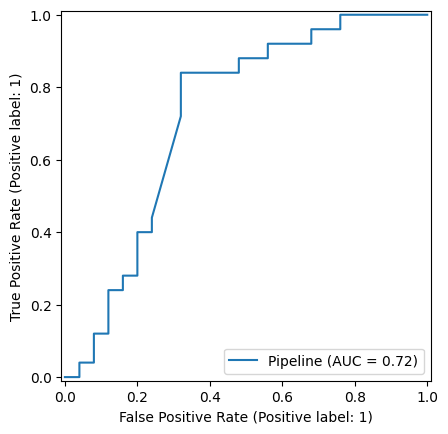

In [15]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Plotting the ROC curve
y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)

RocCurveDisplay.from_estimator(best_model, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [66 70] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Text(0.5, 1.0, 'Learning Curve')

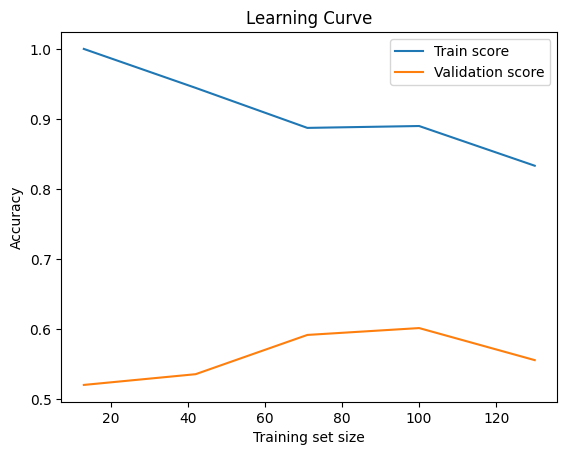

In [16]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Plotting the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=3, scoring='accuracy')

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train score')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Validation score')
plt.legend()
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')